In [1]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn


from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, plot_confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
iris = datasets.load_iris()

# Create a dataframe
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)

# Map numeric target to label names
target_names = list(map(lambda x: iris.target_names[x], iris.target))

# Add target names to the dataframe
df['target'] = target_names

df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [3]:
df.dtypes

sepal length (cm)    float64
sepal width (cm)     float64
petal length (cm)    float64
petal width (cm)     float64
target                object
dtype: object

In [4]:
# Load iris dataset
X = iris.data
y = iris.target

In [5]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [6]:
# Define the models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42)
}


In [7]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("iris_multiclass")

<Experiment: artifact_location='mlflow-artifacts:/533937504517785616', creation_time=1695457492856, experiment_id='533937504517785616', last_update_time=1695457492856, lifecycle_stage='active', name='iris_multiclass', tags={}>

d:\Anaconda\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
d:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
d:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
d:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix i

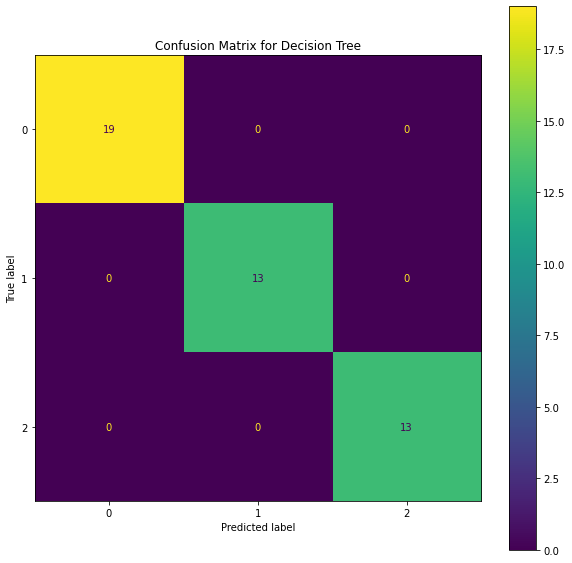

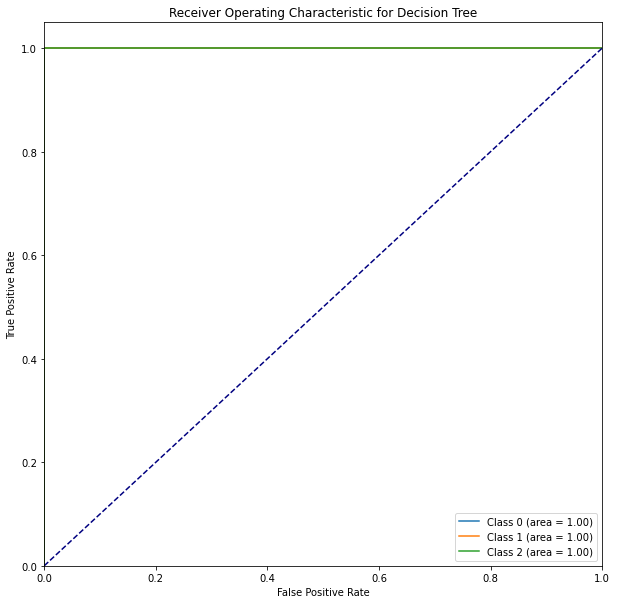

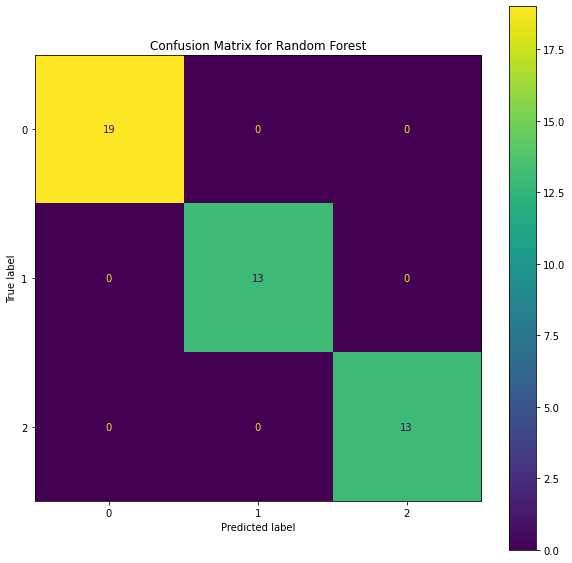

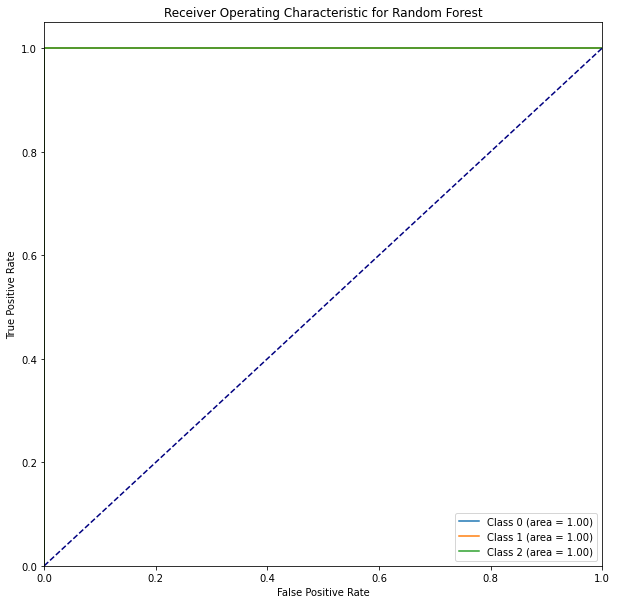

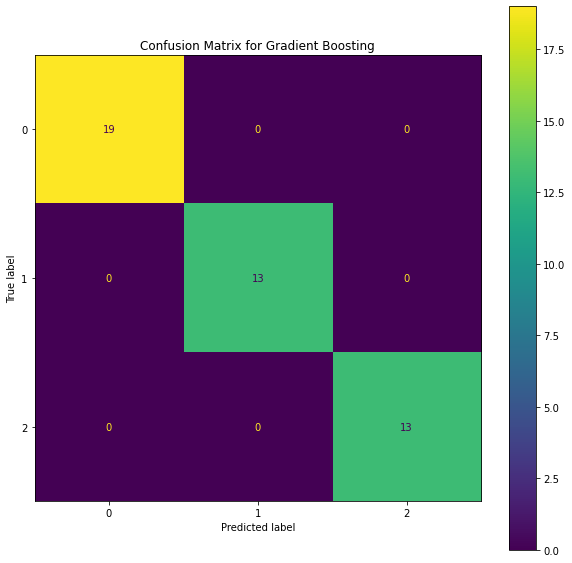

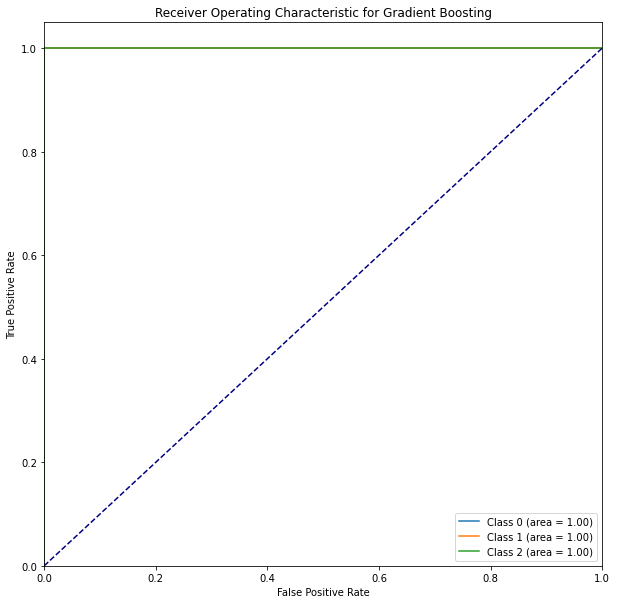

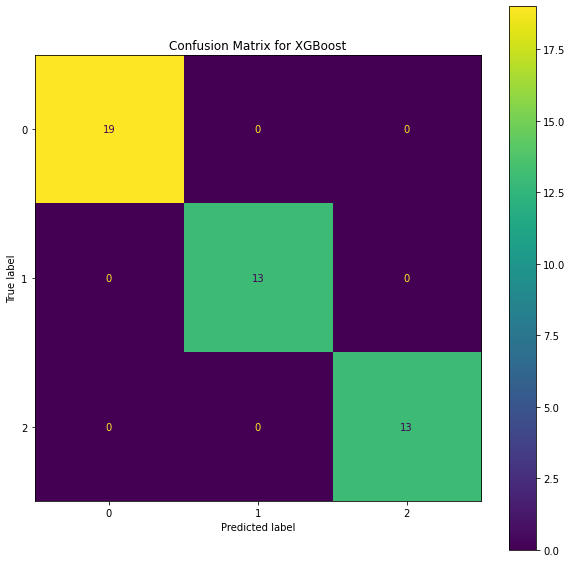

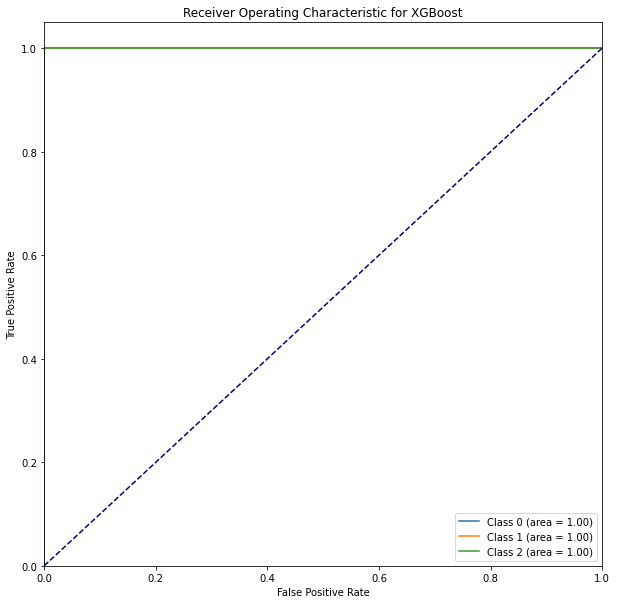

In [8]:
# Compare models
for model_name, model in models.items():
    with mlflow.start_run(run_name=model_name + " default"):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Compute metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        
        # Compute AUC-ROC for multiclass
        y_test_bin = label_binarize(y_test, classes=np.unique(y))
        y_pred_bin = label_binarize(y_pred, classes=np.unique(y))
        roc_auc = roc_auc_score(y_test_bin, y_pred_bin, average='macro', multi_class='ovo')

        # Log metrics into MLflow
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1", f1)
        mlflow.log_metric("roc_auc", roc_auc)
        
        # Log parameters
        params = model.get_params()
        mlflow.log_params(params)
        
        # Log data information as tags
        mlflow.set_tag("num_features", X_train.shape[1])
        mlflow.set_tag("num_samples", X_train.shape[0])
        
        # Log a sample of the data
        sample_rows = 5
        sample_data = pd.DataFrame(X_train[:sample_rows], columns=iris.feature_names).assign(target=y_train[:sample_rows])
        mlflow.log_text(sample_data.to_csv(index=False), "sample_data.csv")
        
        # Log the model
        if isinstance(model, XGBClassifier):
            mlflow.xgboost.log_model(model, "model")
        else:
            mlflow.sklearn.log_model(model, "model")

        # Plot and save confusion matrix
        fig, ax = plt.subplots(figsize=(10, 10))
        plot_confusion_matrix(model, X_test, y_test, ax=ax)
        plt.title(f'Confusion Matrix for {model_name}')
        plt.savefig(f"{model_name}_confusion_matrix.png")
        
         # Plot and save ROC curve
        fig, ax = plt.subplots(figsize=(10, 10))
        
        for i in range(len(np.unique(y))):
             fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
             ax.plot(fpr, tpr, label=f'Class {i} (area = {auc(fpr, tpr):.2f})')
            
        ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'Receiver Operating Characteristic for {model_name}')
        ax.legend(loc="lower right")
        
        plt.savefig(f"{model_name}_roc_curve.png")
        
        # Log plots as artifacts
        mlflow.log_artifact(f"{model_name}_confusion_matrix.png")
        mlflow.log_artifact(f"{model_name}_roc_curve.png")


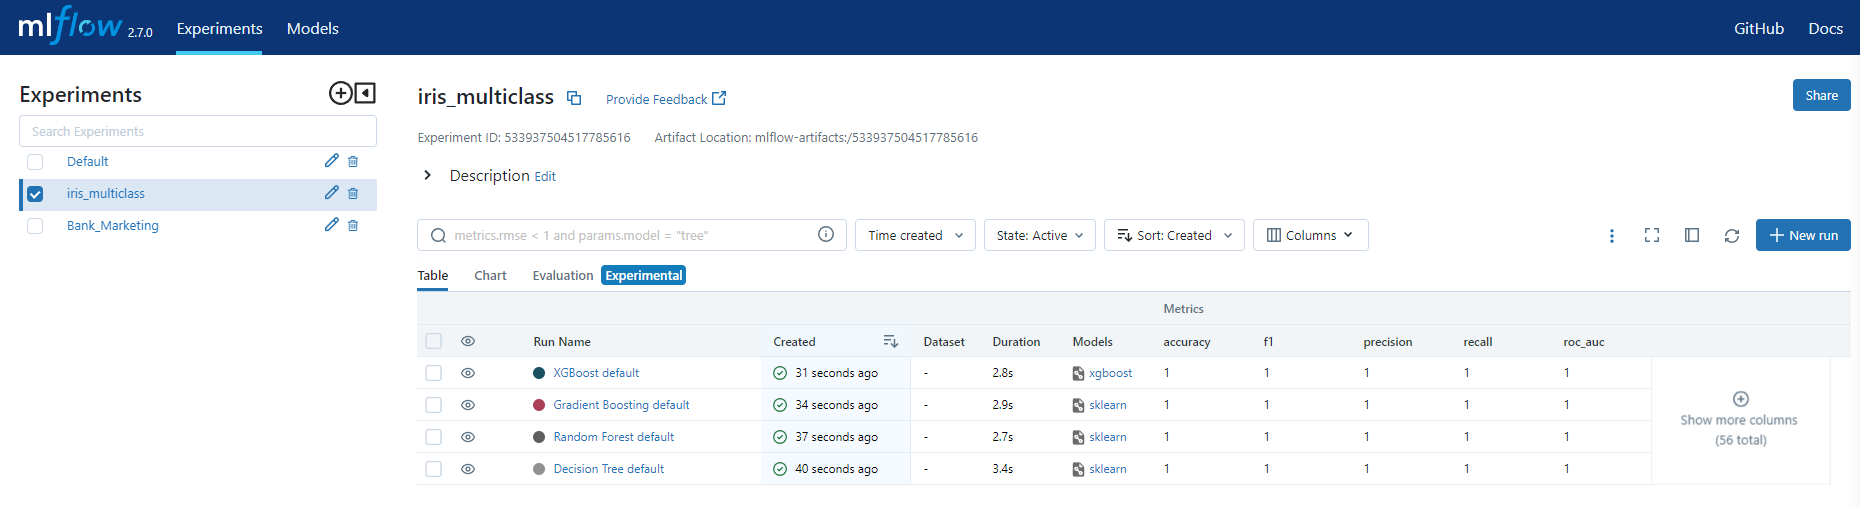

In [9]:
from IPython.display import Image
Image("D:\Kuliah\semester_3\kecerdasan_buatan\Pertemuan_3\Iris-Classification\Screenshot 2023-09-23 113944.png")